In [297]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
import pandas as pd 
import imblearn
import seaborn as sns
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

# Datos desequilibrados

Enrique Macip Belmonte y Maria Ruiz Teixidor.

<img src="australia.jpg">

Los datos usados para esta parte de la práctica son los mismos que en el apartado anterior y otras prácticas de ML. Los datos obtenidos de Kaggle tienen la **información meteorológica de varios años en Australia**, datos en los que viene incluida desde la velocidad del viento hasta la temperatura, en total 23 variables recogidas durante varios años en distintas ciudades de Australia con las que se obtienen un dataset de 140.000 líneas aproximadamente.

Nuestro objetivo será **predecir si llueve o no el día siguiente a partir los datos metereológicos del día**. Nos interesará tener una matriz de confusión dónde los verdaderos positivos y los verdaderos negativos sean altos. Sobretodo nos interesará que el modelo **prediga bien los días en los que sí llueve el día siguiente: verdaderos positivos**. Por lo que nos vamos a centrar en la sensibilidad para poder contestar a la pregunta ¿Qué proporción de días de lluvia se han identificado correctamente?

Con este dataset tan grande lo primero que nos planteamos fue centrarnos en dos cosas:

 - Utilizar una zona concreta de Australia, sacada de la variable localización, de la cual elegimos 4 ciudades situadas en la costa sureste de Australia.

 - Utilizar la variable temporal de alguna forma, ya que considerabamos que tenía importancia pero no podíamos usar cada día del año como un dato diferente, por lo que decidimos obtener a partir de la fecha la estación del año en la que estaba cada línea.


Los datasets son los que se han usado previamente en otras prácticas, de manera que ya están con la adecuada imputación de nulos y divididos correctamente: 

- 80% training
- 10% test
- 10% validación

In [4]:
df_train = pd.read_csv("datasets/df_train.csv") 
df_test = pd.read_csv("datasets/df_test.csv") 
df_validacion = pd.read_csv("datasets/df_validacion.csv") 

In [5]:
del df_train['Unnamed: 0']
del df_test['Unnamed: 0']
del df_validacion['Unnamed: 0']

In [6]:
df_test.head(2)

,Date,Season,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2013-10-26,spring,Adelaide,7.0,22.8,0.0,5.7,7.6,W,26,...,58,19,1027.7,1024.5,8,8,14.1,22.5,0,0
1,2014-12-10,summer,Sydney,20.4,25.3,0.0,5.0,2.6,E,33,...,73,69,1014.8,1011.4,6,7,22.5,24.7,0,1


Seleccionamos las variables que sabemos que son significativas gracias a la prática anterior, con la que finalmente elegimos como mejor modelo un Random Forest:

In [7]:
y_train = df_train['RainTomorrow']
y_test = df_test['RainTomorrow']
y_validacion = df_validacion['RainTomorrow']

X_train_aux = df_train[["MinTemp", "MaxTemp", "Rainfall","Evaporation", "Sunshine", "WindGustDir","WindGustSpeed", "WindDir9am", "WindDir3pm", "WindSpeed9am",  "WindSpeed3pm",  "Humidity9am",  "Humidity3pm",  "Pressure9am", "Pressure3pm", "Temp9am","Temp3pm"]]
X_test_aux = df_test[["MinTemp", "MaxTemp", "Rainfall","Evaporation", "Sunshine", "WindGustDir","WindGustSpeed", "WindDir9am", "WindDir3pm", "WindSpeed9am",  "WindSpeed3pm",  "Humidity9am",  "Humidity3pm",  "Pressure9am", "Pressure3pm", "Temp9am","Temp3pm"]]
X_validacion_aux = df_validacion[["MinTemp", "MaxTemp", "Rainfall","Evaporation", "Sunshine", "WindGustDir","WindGustSpeed", "WindDir9am", "WindDir3pm", "WindSpeed9am",  "WindSpeed3pm",  "Humidity9am",  "Humidity3pm",  "Pressure9am", "Pressure3pm", "Temp9am","Temp3pm"]]

In [8]:
X_train_aux.head(3)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
0,1.3,19.0,0.0,2.2,9.4,NNW,30,SE,NW,7,15,87,34,1024.7,1021.4,7.9,18.6
1,11.2,23.2,0.0,7.6,12.6,SW,41,S,SW,17,20,45,41,1026.7,1024.8,16.7,21.9
2,-4.0,14.1,0.0,4.2,8.3,SW,30,N,SSE,7,11,69,40,1032.7,1029.9,2.9,13.4


Debido a que en la anterior práctica de ML se obtuvieron los mejores resultados con **Random Forest**, se va a seleccionar este modelo con el que hacer las pruebas y comparar resultados. Convertimos las variables categóricas a variables a una codificación numérica ya que el Random Forest puede quedar desequilibrado si hay muchas variables dummies.

In [9]:
replace_map = {'WindGustDir': {'NNW': 1, 'SW': 2, 'SSW': 3, 'N': 4, 'WNW': 5, 'WSW': 6, 'ENE': 7 , 'SE': 8 , 'ESE': 9,'W': 10,'S': 11, 'NW': 12, 'NE': 13, 'E': 14, 'SSE':15, 'NNE':16},
               'WindDir3pm': {'NNW': 1, 'SW': 2, 'SSW': 3, 'N': 4, 'WNW': 5, 'WSW': 6, 'ENE': 7 , 'SE': 8 , 'ESE': 9,'W': 10,'S': 11, 'NW': 12, 'NE': 13, 'E': 14, 'SSE':15, 'NNE':16},
               'WindDir9am': {'NNW': 1, 'SW': 2, 'SSW': 3, 'N': 4, 'WNW': 5, 'WSW': 6, 'ENE': 7 , 'SE': 8 , 'ESE': 9,'W': 10,'S': 11, 'NW': 12, 'NE': 13, 'E': 14, 'SSE':15, 'NNE':16}}

In [10]:
X_train = X_train_aux.copy()
X_test = X_test_aux.copy()
X_validacion = X_validacion_aux.copy()

X_train.replace(replace_map, inplace=True)
X_test.replace(replace_map, inplace=True)
X_validacion.replace(replace_map, inplace=True)

In [11]:
X_train.head(3)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
0,1.3,19.0,0.0,2.2,9.4,1,30,8,12,7,15,87,34,1024.7,1021.4,7.9,18.6
1,11.2,23.2,0.0,7.6,12.6,2,41,11,2,17,20,45,41,1026.7,1024.8,16.7,21.9
2,-4.0,14.1,0.0,4.2,8.3,2,30,4,15,7,11,69,40,1032.7,1029.9,2.9,13.4


# 0. Datos desequilibrados

En primer lugar, recordamos cómo son los datos, qué proporción hay de cada clase. Observamos que es un dataset claramente desbalanceado:

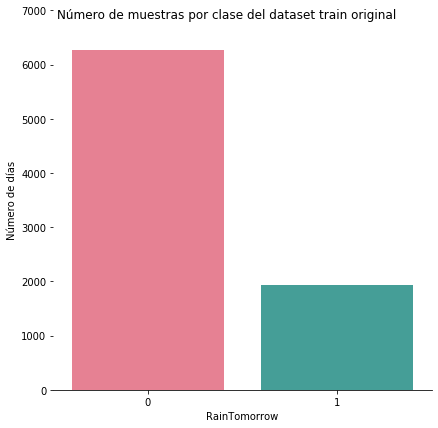

In [12]:
g = sns.catplot(x="RainTomorrow", data=df_train, height=6, kind="count", palette="husl")
g.despine(left=True)
g.set_ylabels("Número de días")
g.fig.suptitle('Número de muestras por clase del dataset train original') 
plt.ylim(0, 7000)
plt.show()

Veamos los resultados que se obtienen sin aplicar ninguna técnica para balancear los datos. Para el Random Forest se usan las **mismas variables** y **parámetros** con los que se obtuvieron los mejores resultados (500 árboles).

Recordamos que con el problema del dataset, predecir los días en los que va a llover, no sólo nos interesa tener un buen accuracy sino también un buen recall, es decir, acertar bien los días en los que sí llueve.

In [13]:
rf = RandomForestClassifier(n_estimators=500, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred), 'Recall:', recall_score(y_test, y_pred))

Accuracy: 0.8564453125 Recall: 0.4744186046511628


Si observamos la matriz de confusión, efectivamente comprobamos que se predicen bien los días en los que no llueve pero el modelo se equivoca en 113 días diciendo que no llueve cuando sí llueve, la mitad aproximadamente.

In [14]:
print('Matriz de confusión:')
print(confusion_matrix(y_test, y_pred))

Matriz de confusión:
[[775  34]
 [113 102]]


# 1. Generación de datos sintéticos (SMOTE)

Este método se basa en los vecinos cercanos a los datos para generar datos sintéticos. Es un método de oversampling, pues crea nuevos datos para llegar a equilibrar la proporción entre las dos clases. Leyendo la documentación, hay un método de SMOTE que es para datasets con variables continuas y categóricas, **SMOTENC**. Probamos a sobre-mostrear con este método.

Como SMOTE es un método que se basa en los vecinos cercanos y para ello en la distancia euclídea, es necesario escalar el dataset:

In [45]:
scaler = StandardScaler()

#columnas numéricas
num_cols_names = ["MinTemp", "MaxTemp", "Rainfall","Evaporation", "Sunshine" ,"WindGustSpeed", "WindSpeed9am",  "WindSpeed3pm",  "Humidity9am",  "Humidity3pm",  "Pressure9am", "Pressure3pm", "Temp9am","Temp3pm"]

#Escalamos el dataset train
scaled_numfeats_train = pd.DataFrame(scaler.fit_transform(X_train[num_cols_names]), 
                                     columns=num_cols_names, index= X_train.index)

In [46]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

#Integramos las columnas escaladas
for col in num_cols_names:
    X_train_scaled[col] = scaled_numfeats_train[col]

In [47]:
#Escalamos el dataset de test
scaled_numfeats_test = pd.DataFrame(scaler.transform(X_test[num_cols_names]),
                                    columns=num_cols_names, index= X_test.index)

#Integramos las columnas escaladas
for col in num_cols_names:
    X_test_scaled[col] = scaled_numfeats_test[col]

Ajustamos SMOTENC, indicando las columnas que son categóricas:

In [48]:
smt = SMOTENC(random_state = 0, categorical_features = [5, 7, 8])

In [49]:
X_train_smote, y_train_smote = smt.fit_sample(X_train_scaled, y_train)

Contamos el número de muestras por cada clase, comprobando que el muestreo ha sido correcto:

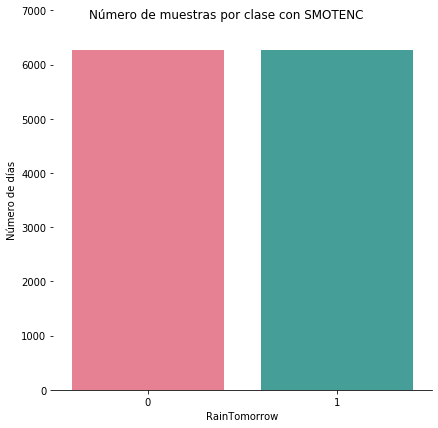

In [50]:
pd_train_smote = y_train_smote.to_frame()
g = sns.catplot(x="RainTomorrow", data=pd_train_smote, height=6, kind="count", palette="husl")
g.despine(left=True)
g.fig.suptitle('Número de muestras por clase con SMOTENC') 
g.set_ylabels("Número de días")
plt.ylim(0, 7000)
plt.show()

Ejecutamos el Random Forest sobre los datos balanceados con SMOTENC:

In [51]:
rf_smote = RandomForestClassifier(n_estimators=500, random_state=0)

Observamos que el accuracy disminuye un poco pero el recall aumenta considerablemente.

In [52]:
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = rf_smote.predict(X_test_scaled)
accuracy_score(y_test, y_pred_smote)
print('Accuracy:', accuracy_score(y_test, y_pred_smote), 'Recall:', recall_score(y_test, y_pred_smote), 'Precision:', precision_score(y_test, y_pred_smote))

Accuracy: 0.8232421875 Recall: 0.6325581395348837 Precision: 0.5714285714285714


Observando la matriz de confusión efectivamente vemos que se reducen los días en los que llueve y se predice que no llueve.

In [42]:
print('Matriz de confusión:')
print(confusion_matrix(y_test, y_pred_smote))

Matriz de confusión:
[[707 102]
 [ 79 136]]


# 2. Sobremuestreo

Probamos otro método para balancear datasets con variables categóricas: submuestreo aleatorio. Se sobremuestrea la clase minoritaria cogiendo muestras aleatoriamente con repuesto.

In [29]:
oversample = RandomOverSampler(random_state=0)

X_train_orandom, y_train_orandom = oversample.fit_resample(X_train, y_train)

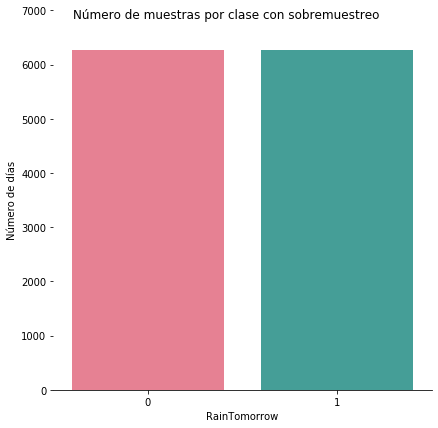

In [30]:
pd_train_orandom = y_train_orandom.to_frame()
g = sns.catplot(x="RainTomorrow", data=pd_train_orandom, height=6, kind="count", palette="husl")
g.despine(left=True)
g.fig.suptitle('Número de muestras por clase con sobremuestreo') 
g.set_ylabels("Número de días")
plt.ylim(0, 7000)
plt.show()

Observamos que este método no es tan efectivo como el SMOTE, el accuracy se mantiene alto pero el recall no aumenta tanto:

In [31]:
rf.fit(X_train_orandom, y_train_orandom)
y_pred_orandom = rf.predict(X_test)
accuracy_score(y_test, y_pred_orandom)
print('Accuracy:', accuracy_score(y_test, y_pred_orandom), 'Recall:', recall_score(y_test, y_pred_orandom), 'Precision:', precision_score(y_test, y_pred_orandom))

Accuracy: 0.8525390625 Recall: 0.5674418604651162 Precision: 0.6777777777777778


In [32]:
print('Matriz de confusión:')
print(confusion_matrix(y_test, y_pred_orandom))

Matriz de confusión:
[[751  58]
 [ 93 122]]


# 3. Submuestreo

Probamos otro método para balancear datasets con variables categóricas: submuestreo aleatorio. Se trata de busmuestrear la clase mayoritaria seleccionando aleatoriamente muestras con o sin repuesto.

In [24]:
undersample = RandomUnderSampler(random_state=0)

X_train_urandom, y_train_urandom = undersample.fit_resample(X_train, y_train)

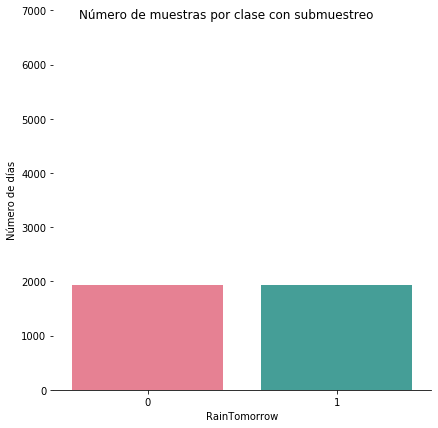

In [25]:
pd_train_urandom = y_train_urandom.to_frame()
g = sns.catplot(x="RainTomorrow", data=pd_train_urandom, height=6, kind="count", palette="husl")
g.despine(left=True)
g.fig.suptitle('Número de muestras por clase con submuestreo') 
g.set_ylabels("Número de días")
plt.ylim(0, 7000)
plt.show()

Observamos que con este método se obtienen buenos resultados a pesar de quitar información al problema. El accuracy disminuye pero el recall aumenta a niveles parecidos, que nos interesa especialmente:

In [28]:
rf.fit(X_train_urandom, y_train_urandom)
y_pred_urandom = rf.predict(X_test)
accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy_score(y_test, y_pred_urandom), 'Recall:', recall_score(y_test, y_pred_urandom), 'Precision:', precision_score(y_test, y_pred_urandom))

Accuracy: 0.76953125 Recall: 0.7395348837209302 Precision: 0.4690265486725664


In [27]:
print('Matriz de confusión:')
print(confusion_matrix(y_test, y_pred_urandom))

Matriz de confusión:
[[629 180]
 [ 56 159]]


# 4. Clases reponderadas

En este método hacemos uso del parámetro de la propia función de sklearn, **class_weight** para indicar que los días en los que llueve tengan más peso en el entrenamiento. Mejoran los resultados pero no tanto como los otros métodos.

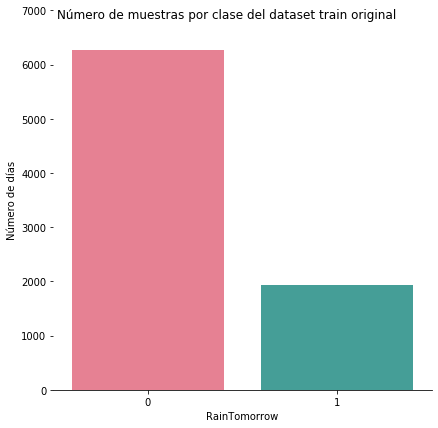

In [76]:
g = sns.catplot(x="RainTomorrow", data=df_train, height=6, kind="count", palette="husl")
g.despine(left=True)
g.set_ylabels("Número de días")
g.fig.suptitle('Número de muestras por clase del dataset train original') 
plt.ylim(0, 7000)
plt.show()

In [43]:
rf = RandomForestClassifier(n_estimators=500, random_state=0, class_weight={0:1,1:2})
rf.fit(X_train, y_train)
y_pred_pond = rf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred_pond), 'Recall:', recall_score(y_test, y_pred_pond), 'Precision:', precision_score(y_test, y_pred_pond))

Accuracy: 0.8623046875 Recall: 0.4883720930232558 Precision: 0.7720588235294118


In [78]:
print('Matriz de confusión:')
print(confusion_matrix(y_test, y_pred_pond))

Matriz de confusión:
[[778  31]
 [110 105]]


# 5. Umbral de probabilidad

Hasta ahora la técnica que ha dado mejores resultados de recall ha sido el submuestreo aleatorio. Sin embargo, la métrica de precision es bastante baja. Por ello se considera que es mejor método de muestreo el SMOTENC, ya que el recall sigue siendo alto y superior al precision y no toman valores tan diferentes.

Veamos, a partir de este muestreo y con el Random Forest, cómo cambiaría la matriz de confusión a la hora de mover el umbral de decisión entre una clase y otra.

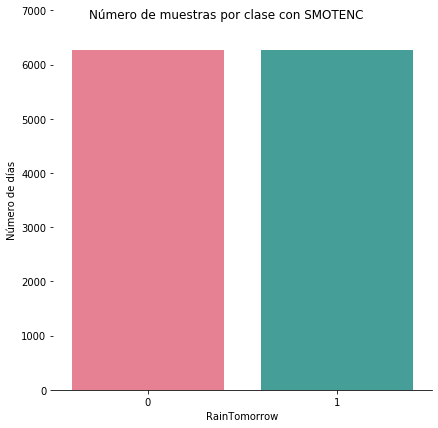

In [54]:
pd_train_smote = y_train_smote.to_frame()
g = sns.catplot(x="RainTomorrow", data=pd_train_smote, height=6, kind="count", palette="husl")
g.despine(left=True)
g.fig.suptitle('Número de muestras por clase con SMOTENC') 
g.set_ylabels("Número de días")
plt.ylim(0, 7000)
plt.show()

Representamos, en función del umbral elegido, cómo varían los valores recall y precision, con el objetivo de determinar el valor que más nos interese. Obtenemos las probabilidades a partir del Random Forest inicial. Calculamos los valores  de precision, recall para diferentes valores del umbral.

In [60]:
y_pred_prob = rf_smote.predict_proba(X_test_scaled)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob[:, 1])

Representamos la gráfica Precision - Recall:

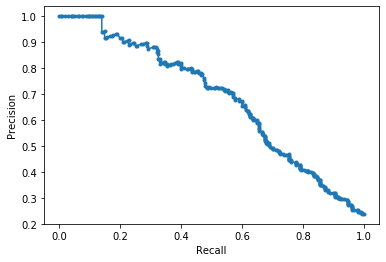

In [61]:
plt.plot(recall, precision, marker='.', label='RandomForest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Observamos los mismos datos pero con el threshold en el eje X, de esta manera podremos evaluar mejor qué valor elegir:

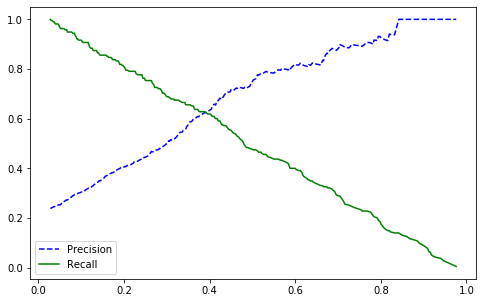

In [62]:
def plot_precision_recall_vs_threshold(precisions, recall, thresholds): 
    fig = plt.figure(figsize= (8,5))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    plt.legend()

plot_precision_recall_vs_threshold(precision, recall, thresholds)

Vemos que para 0.40 aproximadamente se obtienen valores parecidos de ambas métricas, alrededor de 0.6. Como nos interesa sobretodo un buen recall elegimos un umbral algo menor: 0.32 para que no baje mucho el precision tampoco.

In [64]:
rf_smote = RandomForestClassifier(n_estimators=500, random_state=0)
rf_smote.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=500, random_state=0)

In [65]:
threshold = 0.32

predicted_proba = rf_smote.predict_proba(X_test_scaled)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

print('Accuracy:', accuracy_score(y_test, predicted), 'Recall:', recall_score(y_test, predicted), 'Precision:', precision_score(y_test, predicted))

Accuracy: 0.8017578125 Recall: 0.6744186046511628 Precision: 0.5215827338129496


In [66]:
print('Matriz de confusión:')
print(confusion_matrix(y_test, predicted))

Matriz de confusión:
[[676 133]
 [ 70 145]]


# Conclusiones

Finalmente se ha decidido optar por realizar un SMOTENC y posteriormente modificar el umbral de decisión, por tener un mejor equilibrado entre recall - precision. Sin embargo, si se quisiera claramente apostar por predecir mejor los días que llueve a pesar de equivocarse en muchos en los que no llueve se podría modificar el umbral o bien utilizar el submuestreo. Todo depende de la finalidad que se quiera con el modelo.